## Using the API to Dynamically Adjust River Conductance

In this example, we are going to use the API to modify the river package so that the conductance is greater when the groundwater system is discharging to the river and smaller when the river is discharging to the aquifer. The results generated using the API will be compare to the approach used in [Zaadnoordijk (2009)](https://doi.org/10.1111/j.1745-6584.2009.00582.x), where the combination of a general head and drain boundaries were used to increase the conductance when the aquifer is discharging to the river.

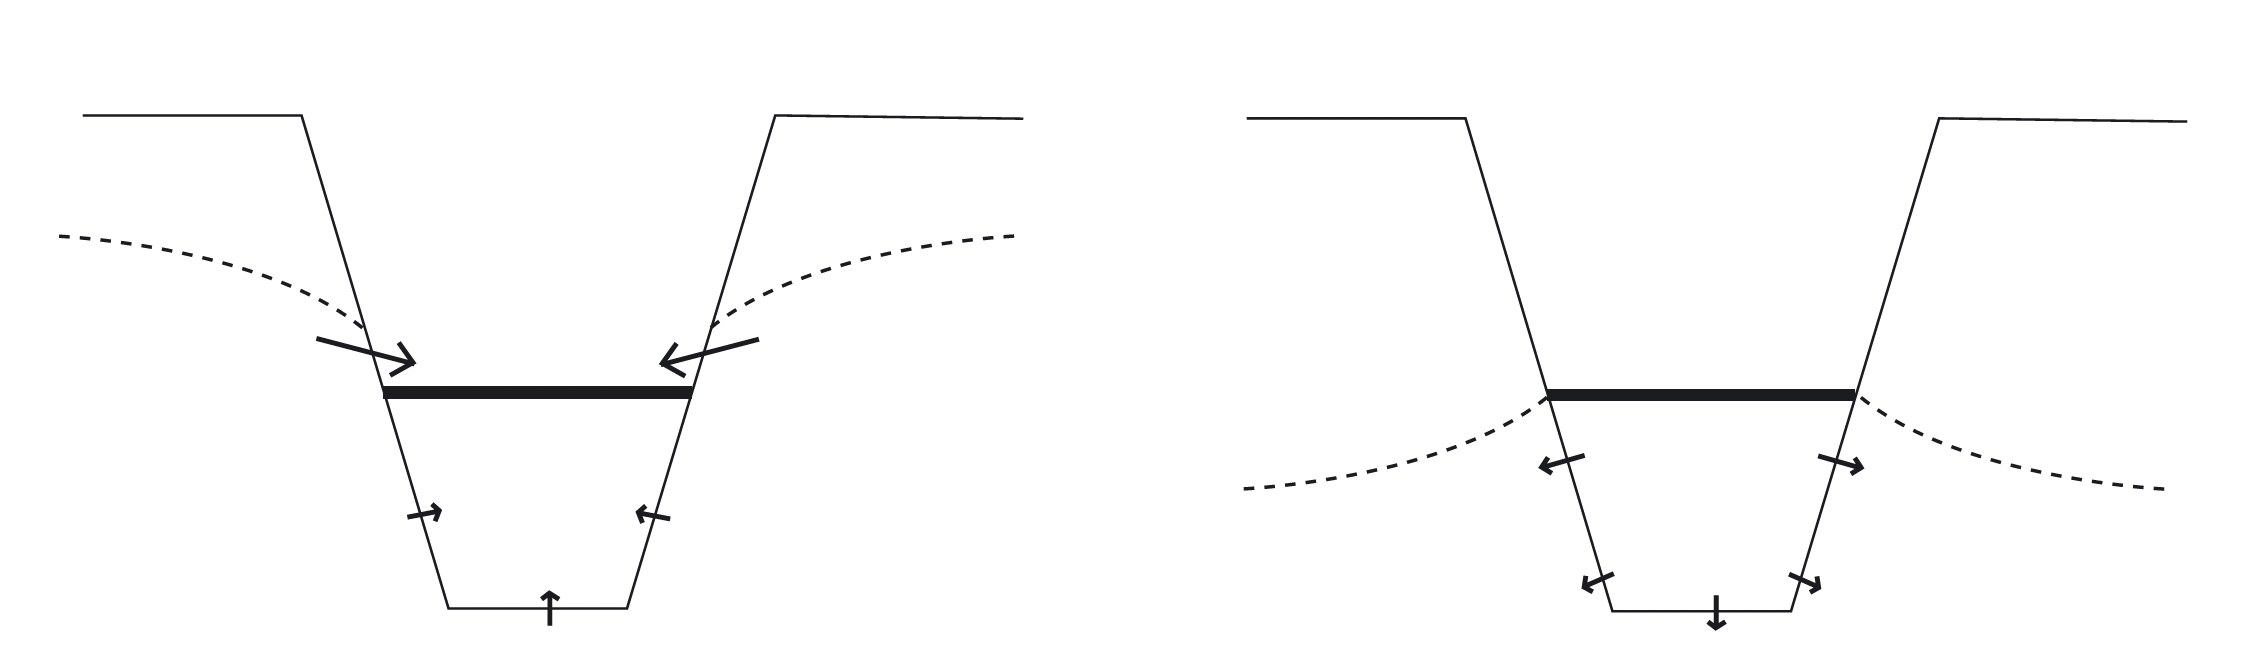

### Imports

In [ ]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib as pl
import platform

import flopy.mf6 as fp
import flopy.plot.styles as styles


### Set path to the shared MODFLOW object

In [ ]:
_platform = platform.system() 
_DLL_PATH = pl.Path(os.getenv('CONDA_PREFIX'))
if _platform == "Windows":
    _DLL_PATH = _DLL_PATH / "Scripts"
else:
    _DLL_PATH = _DLL_PATH / "bin"
if _platform == "Linux":
    _ext = ".so"
elif _platform == "Darwin":
    _ext = ".dylib"
else:
    _ext = ".dll"
libmf6 = (_DLL_PATH / f"libmf6{_ext}").resolve()

In [ ]:
print(f"libmf6 exists {libmf6.is_file()}\nPath to libmf6 '{libmf6}'")

### Set base model path

In [ ]:
name = "model"
base_ws = pl.Path("temp/zaadnoordijk")

### Create the sinusoidal boundary condition

In [ ]:
h_mean, h_min, h_max = 320., 315., 325.

In [ ]:
amplitude = (h_min - h_max) / 2.

In [ ]:
ntimesteps = 401
ihalf = int(ntimesteps/2) + 1
x = np.linspace(-np.pi, np.pi, ntimesteps)
chd_head = amplitude * np.sin(x) + h_mean

### Create a model based on approach of [Zaadnoordijk (2009)](https://doi.org/10.1111/j.1745-6584.2009.00582.x)

In [ ]:
ws = base_ws / "ghb"
sim = fp.MFSimulation(sim_name=name, sim_ws=ws, memory_print_option="all")
pd = [(1, 1, 1.)] * chd_head.shape[0]
tdis = fp.ModflowTdis(sim, nper=len(pd), perioddata=pd)
ims = fp.ModflowIms(sim, complexity="simple", outer_dvclose=1e-6, inner_dvclose=1e-6)
gwf = fp.ModflowGwf(
    sim,
    modelname=name, 
    print_input=True, 
    save_flows=True,
)
dis = fp.ModflowGwfdis(
    gwf, 
    nlay=2, 
    nrow=1, 
    ncol=1, 
    delr=1., 
    delc=1.,
    top=360, 
    botm=[220, 200],
)
npf = fp.ModflowGwfnpf(
    gwf, 
    k=50., 
    k33=10.,
)
ic = fp.ModflowGwfic(gwf, strt=chd_head[0])
condref = 1.
spd = [((0, 0, 0), h_mean, 0.25 * condref)]
ghb = fp.ModflowGwfghb(gwf, stress_period_data=spd, pname="GHB", print_flows=True)
spd = [((0, 0, 0), h_mean, 0.75 * condref)]
drn = fp.ModflowGwfdrn(gwf, stress_period_data=spd, pname="RIVER", print_flows=True)
spd = {idx: [((1, 0, 0), h)] for idx, h in enumerate(chd_head)}
chd = fp.ModflowGwfchd(gwf, stress_period_data=spd, print_flows=True)
oc = fp.ModflowGwfoc(
    gwf,
    head_filerecord=f"{name}.hds",
    budget_filerecord=f"{name}.cbc",
    printrecord=[("budget", "all")],
    saverecord=[("head", "all"), ("budget", "all")],
)
sim.write_simulation()
sim.run_simulation(silent=True)

Extract the combined general head and drain boundary flow.

In [ ]:
cobj = gwf.output.budget()
cobj.get_unique_record_names()

In [ ]:
cobj = gwf.output.budget()
ghb_q = []
for totim in cobj.get_times():
    ghb_q.append(
        cobj.get_data(totim=totim, text="drn")[0]['q'].sum() + 
        cobj.get_data(totim=totim, text="ghb")[0]['q'].sum()
    )
ghb_q = np.array(ghb_q)

### Create a model with a river stress package

In [ ]:
ws = base_ws / "riv"
sim = fp.MFSimulation(sim_name=name, sim_ws=ws, memory_print_option="all")
pd = [(1, 1, 1.)] * chd_head.shape[0]
tdis = fp.ModflowTdis(sim, nper=len(pd), perioddata=pd)
ims = fp.ModflowIms(sim, complexity="simple", outer_dvclose=1e-6, inner_dvclose=1e-6)
gwf = fp.ModflowGwf(
    sim,
    modelname=name, 
    print_input=True, 
    save_flows=True,
)
dis = fp.ModflowGwfdis(
    gwf, 
    nlay=2, 
    nrow=1, 
    ncol=1, 
    delr=1., 
    delc=1.,
    top=360, 
    botm=[220, 200],
)
npf = fp.ModflowGwfnpf(
    gwf, 
    k=50., 
    k33=10.,
)
ic = fp.ModflowGwfic(gwf, strt=chd_head[0])
condref = 1.
spd = [((0, 0, 0), h_mean, condref, 319.)]
riv = fp.ModflowGwfriv(gwf, stress_period_data=spd, pname="RIVER", print_flows=True)
spd = {idx: [((1, 0, 0), h)] for idx, h in enumerate(chd_head)}
chd = fp.ModflowGwfchd(gwf, stress_period_data=spd, print_flows=True)
oc = fp.ModflowGwfoc(
    gwf,
    head_filerecord=f"{name}.hds",
    budget_filerecord=f"{name}.cbc",
    printrecord=[("budget", "all")],
    saverecord=[("head", "all"), ("budget", "all")],
)
sim.write_simulation()


### Run API Model with Modified River Conductance

In [ ]:
import modflowapi
from modflowapi.extensions import ApiSimulation
from modflowapi import Callbacks

In [ ]:
def callback_function(sim, callback_step):
    """
    Reduce the river conductance when the river stage is 
    greater than the groundwater head
    
    Parameters
    ----------
    sim : modflowapi.Simulation
        A simulation object for the solution group that is 
        currently being solved
    callback_step : enumeration
        modflowapi.Callbacks enumeration object that indicates
        the part of the solution modflow is currently in.
    """
    if callback_step == Callbacks.initialize:
        print(sim.models)
    if callback_step == Callbacks.iteration_start:
        riv = sim.model.river
        spd = sim.model.river.stress_period_data.values
        if sim.model.X[0, 0, 0] > h_mean:
            cond = condref
        else:
            cond = condref * 0.25
        spd[0] = ((0, 0, 0), h_mean, cond, 319.)
        sim.model.river.stress_period_data.values = spd
    

In [ ]:
modflowapi.run_simulation(libmf6, ws, callback_function, verbose=True)

Extract the river boundary flow

In [ ]:
cobj = gwf.output.budget()
riv_q_api = []
for totim in cobj.get_times():
    riv_q_api.append(cobj.get_data(totim=totim, text="riv")[0]['q'].sum())
riv_q_api = np.array(riv_q_api)

### Plot the results

In [ ]:
with styles.USGSPlot():
    axd = plt.figure(
        layout="constrained",
        figsize=(9, 5),
    ).subplot_mosaic(
        """
        ab
        """,
        empty_sentinel="X",
    )
    for key in axd.keys():
        axd[key].set_xlim(0, ntimesteps)
        axd[key].set_xlabel("Simulation Time, days")
    
    ax = axd["a"]
    ax.fill_between(cobj.get_times()[ihalf:], y1=h_mean, y2=chd_head[ihalf:], color="blue", ec="blue", label="Recharge") 
    ax.fill_between(cobj.get_times()[:ihalf], y1=h_mean, y2=chd_head[:ihalf], color="red", ec="red", label="Discharge") 
    ax.axhline(y=h_mean, color="black", lw=1.25, ls="--", label="River Stage")
    ax.axhline(y=319, color="black", lw=1.25, ls=":", label="River Bottom")
    ax.set_ylabel("Groundwater Head, m")
    styles.graph_legend(ax=ax)
    
    ax = axd["b"]
    ax.plot(cobj.get_times(), ghb_q, color="blue", lw=0.5, ls="--", label="GHB + DRN");
    ax.plot(cobj.get_times(), riv_q_api, color="green", lw=0.75, label="RIVER API");
    ax.set_ylabel("Flow Rate, m$^3$/d")
    styles.graph_legend(ax=ax)
    